In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from pandas_datareader import data as pdr

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

## Data preprocessing

In [9]:
import yfinance as yfin


yfin.pdr_override()

dataset_train = pdr.get_data_yahoo('X', start='2012-01-02', end='2021-01-01')

training_set = dataset_train.iloc[:, 1:2].values
print(len(training_set))

[*********************100%%**********************]  1 of 1 completed
2265


In [11]:
dataset_train.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,27.420000,28.480000,27.420000,28.170000,25.467098,11470000
2012-01-04,28.000000,28.730000,27.799999,28.440001,25.711203,8549700
2012-01-05,28.170000,28.299999,27.510000,27.790001,25.123568,9099200
2012-01-06,28.030001,28.200001,27.180000,27.299999,24.680582,9081900
2012-01-09,27.459999,27.740000,26.639999,26.780001,24.210470,8010600


<AxesSubplot:xlabel='Date'>

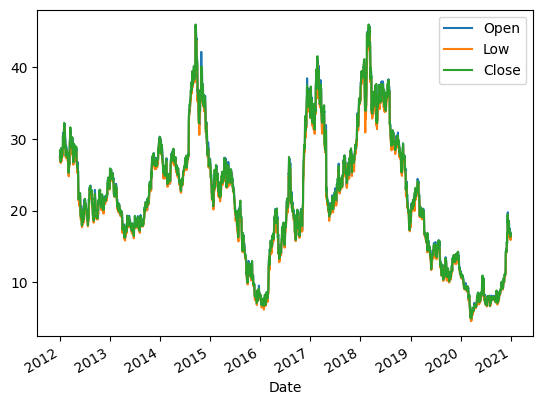

In [12]:
dataset_train[['Open', 'Low', 'Close']].plot()

In [13]:
# We scale here the training data
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# We create a data structure with 60 timesteps and 1 output
X_train = []
y_train = []

length_training = len(training_set)
for i in range(60, length_training):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Building and training the RNN model

In [16]:
from datetime import datetime, timedelta

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [ ]:

regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))


regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))


regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))


In [ ]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

## Inference on the test set

In [ ]:
# We test on the data fetched from Yahoo's API, between the following years :

dataset_test = pdr.get_data_yahoo('X', start='2021-01-02', end='2023-11-20')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [ ]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)

# we preprocess our inputs

inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)


X_test = []

for i in range(60, 80):
    X_test.append(inputs[i-60:i, 0])
    

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('X (ex. twitter) Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('X Stock Price')
plt.legend()
plt.show()

In [31]:
def are_r_consecutive(date_str1, date_str2, r):
    
    date1 = dt.datetime.strptime(date_str1, '%Y-%m-%d')
    date2 = dt.datetime.strptime(date_str2, '%Y-%m-%d')

    return (date2 - date1) == timedelta(days=r)

In [35]:
are_r_consecutive('2012-01-31', '2012-02-01', 1)

True

In [58]:
str(dataset_train.index[0]).split(' ')[0]

"DatetimeIndex(['2012-01-03',"

In [ ]:
# Calculating the probability p and slope
slide_size = 100
p = 0
slope_up = []
slope_down = []
previous_day = dataset_train.tail(slide_size)['Open'][0]

for element in dataset_train.tail(slide_size-1)['Open']:
    if element>=previous_day :
        p += 1/slide_size
        slope_up.append(element-previous_day)
    else :
        slope_down.append(element-previous_day)
    previous_day = element
